In [1]:
import  tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import concatenate

2022-07-12 23:45:42.667965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 23:45:42.668332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Autoencoder for multi-omics data integration


*   Load and preview CITE-Seq data
*   Principle Component Analysis (PCA)
*   t-SNE
*   Autoencoder
*   Tensorflow Sequential Model
*   Challenge 1: build your simple autoencoder
*   Tensorflow Functional API
*   Challenge 2: improve the AUTOENCODER multi-omics model




In [2]:
# code and data adopted from https://raw.githubusercontent.com/NikolayOskolkov/DeepLearningDataIntegration

# to download the data
# !wget https://raw.githubusercontent.com/NikolayOskolkov/DeepLearningDataIntegration/master/scRNAseq.txt
# !wget https://raw.githubusercontent.com/NikolayOskolkov/DeepLearningDataIntegration/master/scProteomics.txt

## load and preview CITE-Seq data

from wikipedia:


> *CITE-Seq (Cellular Indexing of Transcriptomes and Epitopes by Sequencing) is a method for performing RNA sequencing along with gaining quantitative and qualitative information on surface proteins with available antibodies on a single cell level*


In [3]:
# an important package is missing, please import it below


In [6]:
scRNAseq = pd.read_csv('scRNAseq.txt',sep='\t')
scProteomics = pd.read_csv('scProteomics.txt',sep='\t')

scRNAseq.info()
scRNAseq.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8617 entries, CTGTTTACACCGCTAG to ACACGACGCTCTTCCG
Columns: 977 entries, ABHD17A to cluster
dtypes: int64(977)
memory usage: 64.3+ MB


,ABHD17A,ABHD5,ABI3,AC013264.2,AC017104.6,AC092580.4,AC093673.5,AC132872.2,ACRBP,ACSL1,...,MOUSE_Ppp1ca,MOUSE_Cald1,MOUSE_Rps26,MOUSE_Ctsl,MOUSE_Tnfrsf12a,MOUSE_Esd,MOUSE_Acta2,MOUSE_Arpc2,MOUSE_Calr,cluster
CTGTTTACACCGCTAG,0,0,0,0,0,0,0,0,0,0,...,38,161,22,133,57,58,5,66,21,4
CTCTACGGTGTGGCTC,0,0,0,0,0,0,0,0,0,0,...,67,85,60,77,55,70,69,52,33,4
AGCAGCCAGGCTCATT,0,0,0,0,0,0,0,0,1,0,...,69,87,60,112,74,37,27,68,76,4
GAATAAGAGATCCCAT,0,0,0,0,0,0,0,0,0,0,...,71,87,84,67,44,80,31,62,107,4
GTGCATAGTCATGCAT,0,0,0,0,0,0,0,0,0,0,...,88,128,58,23,29,13,547,93,31,4


In [7]:
scProteomics.info()
scProteomics.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8617 entries, CTGTTTACACCGCTAG to ACACGACGCTCTTCCG
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   CITE_CD3     8617 non-null   int64
 1   CITE_CD4     8617 non-null   int64
 2   CITE_CD8     8617 non-null   int64
 3   CITE_CD45RA  8617 non-null   int64
 4   CITE_CD56    8617 non-null   int64
 5   CITE_CD16    8617 non-null   int64
 6   CITE_CD11c   8617 non-null   int64
 7   CITE_CD14    8617 non-null   int64
 8   CITE_CD19    8617 non-null   int64
 9   CITE_CD34    8617 non-null   int64
 10  cluster      8617 non-null   int64
dtypes: int64(11)
memory usage: 807.8+ KB


,CITE_CD3,CITE_CD4,CITE_CD8,CITE_CD45RA,CITE_CD56,CITE_CD16,CITE_CD11c,CITE_CD14,CITE_CD19,CITE_CD34,cluster
CTGTTTACACCGCTAG,60,72,76,575,64,161,77,206,70,179,4
CTCTACGGTGTGGCTC,52,49,59,3943,68,107,65,129,665,79,4
AGCAGCCAGGCTCATT,89,112,61,682,87,117,65,169,79,78,4
GAATAAGAGATCCCAT,55,66,56,378,58,82,44,136,49,83,4
GTGCATAGTCATGCAT,63,80,94,644,104,168,92,164,81,152,4


normalisation is important in single cell sequencing data
* in this data, we use log(x+1) transformation

In [8]:
# an important package is missing, please import it below


In [9]:
X_scRNAseq = scRNAseq.values[:,0:(scRNAseq.shape[1]-1)]
Y_scRNAseq = scRNAseq.values[:,scRNAseq.shape[1]-1]
X_scProteomics = scProteomics.values[:,0:(scProteomics.shape[1]-1)]
Y_scProteomics = scProteomics.values[:,scProteomics.shape[1]-1]

X_scRNAseq = np.log(X_scRNAseq + 1)
X_scProteomics = np.log(X_scProteomics + 1)

## Principle Component Analysis

PCA is the most popular dimensionality reduction method. The main idea of PCA is to identify projections which maintain the maximum amount of variance in the dataset. For visualisation, we normally reduce the dimensionality down to 2 or 3. 

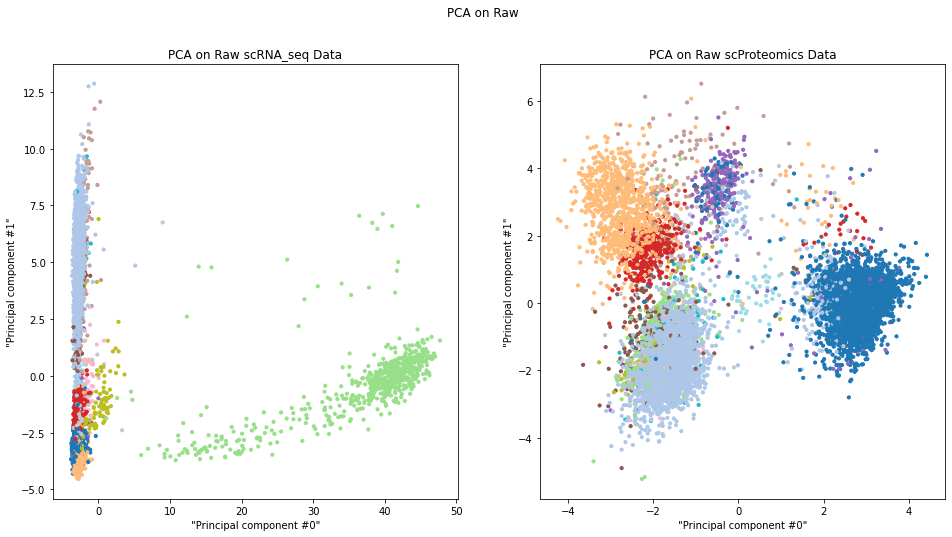

In [10]:
from sklearn.decomposition import PCA

pca_scRNAseq = PCA(n_components=2)
scRNAseq_pca = pca_scRNAseq.fit_transform(X_scRNAseq)

pca_scProteomics = PCA(n_components=2)
scProteomics_pca = pca_scProteomics.fit_transform(X_scProteomics)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('PCA on Raw ')

ax1.scatter(scRNAseq_pca[:, 0], scRNAseq_pca[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
ax1.set_title('PCA on Raw scRNA_seq Data')

ax2.scatter(scProteomics_pca[:, 0], scProteomics_pca[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 10)
ax2.set_title('PCA on Raw scProteomics Data')

for ax in (ax1,ax2):
    ax.set(xlabel='"Principal component #0"', ylabel='"Principal component #1"')

In [11]:
print('Explained variation per principal component: {}'.format(pca_scRNAseq.explained_variance_ratio_))
print('Explained variation per principal component: {}'.format(pca_scProteomics.explained_variance_ratio_))

Explained variation per principal component: [0.5878904  0.08634838]
Explained variation per principal component: [0.39577965 0.24384227]


## t-SNE: t-Distributed Stochastic Neighbor Embedding

t-SNE reduced dimensionality while trying to make instances that are similiar in close distance and move the dissimilar instances apart. It is normally used to visualize data in high-dimensional space. 

In [12]:
# tSNE on scRNAseq
tsne_scRNAseq = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 500, verbose = 1, n_jobs=-1)
scRNAseq_tsne = tsne_scRNAseq.fit_transform(X_scRNAseq)

# tSNE on X_scProteomics
tsne_scProteomics = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 500, verbose = 1, n_jobs=-1)
scProteomics_tsne = tsne_scProteomics.fit_transform(X_scProteomics)

/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.056s...
[t-SNE] Computed neighbors for 8617 samples in 4.978s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 1.575699
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.898125
[t-SNE] KL divergence after 500 iterations: 2.127483
[t-SNE] Computing 271 nearest neighbors...


/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Indexed 8617 samples in 0.375s...
[t-SNE] Computed neighbors for 8617 samples in 0.927s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.471750
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.593323
[t-SNE] KL divergence after 500 iterations: 1.288533


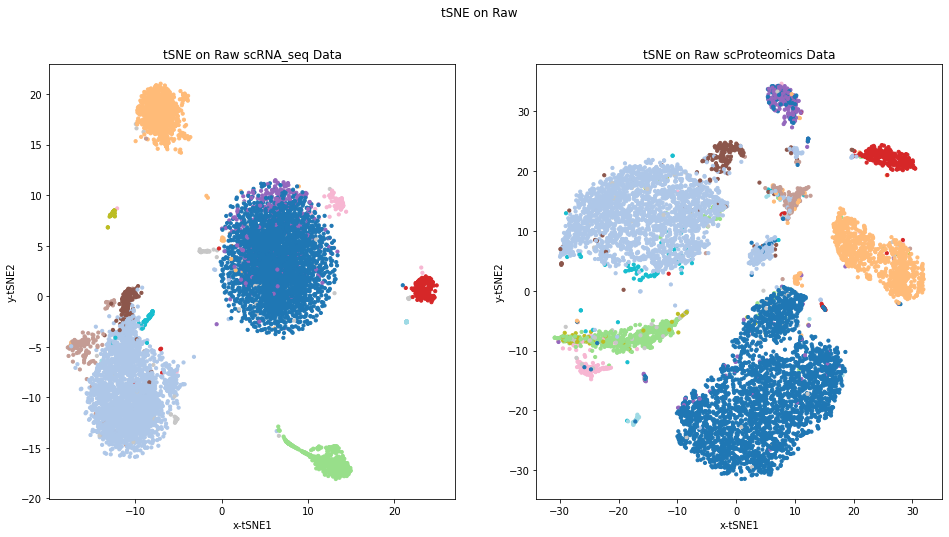

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('tSNE on Raw ')

ax1.scatter(scRNAseq_tsne[:, 0], scRNAseq_tsne[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
ax1.set_title('tSNE on Raw scRNA_seq Data')

ax2.scatter(scProteomics_tsne[:, 0], scProteomics_tsne[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 10)
ax2.set_title('tSNE on Raw scProteomics Data')

for ax in (ax1,ax2):
    ax.set(xlabel='x-tSNE1', ylabel='y-tSNE2')

## Autoencoder using TensorFlow Sequential Model

 Sequential model is built by passing a list of layers to the Sequential constructor. 
 
*   Sequential constructor enable us to build a model layer by layer
*   Inside the sequential constructor, each layer only has one input tensor and one output tensor



In [14]:
# simple Autoencoder Sequential Model
sc_RNAseq_model = Sequential([Input(shape=(X_scRNAseq.shape[1],), name = 'input_layer'),
                              Dense(units = 2, activation = 'linear', name = "bottleneck"),
                              Dense(units = X_scRNAseq.shape[1],   activation = 'linear', name = 'output_layer')
                              ])
# print the model summary
sc_RNAseq_model.summary()

2022-07-10 18:31:12.081744: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-10 18:31:12.081821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-clx-0899.gadi.nci.org.au): /proc/driver/nvidia/version does not exist
2022-07-10 18:31:12.264552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bottleneck (Dense)          (None, 2)                 1954      
                                                                 
 output_layer (Dense)        (None, 976)               2928      
                                                                 
Total params: 4,882
Trainable params: 4,882
Non-trainable params: 0
_________________________________________________________________


we need to configue our model before we train it with data.

In this process, we need to identify three arguments for our model

1.   Loss Function:  is the function your model tries to minimize 
2.   Optimizer: is the function used to adjust the parameters for a model so as to minimize your loss function
3.   Metrics: is the function you used to evaluate your model's performance

In [15]:
sc_RNAseq_model.compile(loss = 'mean_squared_error', 
                        optimizer = 'adam',
                        metrics = ['mse', 'mae'])

history = sc_RNAseq_model.fit(X_scRNAseq, X_scRNAseq, batch_size = 128, epochs = 100, shuffle = True, verbose = 1, validation_split = 0.1)

Epoch 1/100
61/61 [==============================] - 2s 6ms/step - loss: 0.2383 - mse: 0.2383 - mae: 0.1690 - val_loss: 0.1034 - val_mse: 0.1034 - val_mae: 0.1297
Epoch 2/100
61/61 [==============================] - 0s 4ms/step - loss: 0.1421 - mse: 0.1421 - mae: 0.1566 - val_loss: 0.0985 - val_mse: 0.0985 - val_mae: 0.1324
Epoch 3/100
61/61 [==============================] - 0s 3ms/step - loss: 0.1247 - mse: 0.1247 - mae: 0.1611 - val_loss: 0.0792 - val_mse: 0.0792 - val_mae: 0.1347
Epoch 4/100
61/61 [==============================] - 0s 4ms/step - loss: 0.0848 - mse: 0.0848 - mae: 0.1420 - val_loss: 0.0613 - val_mse: 0.0613 - val_mae: 0.1127
Epoch 5/100
61/61 [==============================] - 0s 4ms/step - loss: 0.0744 - mse: 0.0744 - mae: 0.1315 - val_loss: 0.0617 - val_mse: 0.0617 - val_mae: 0.1111
Epoch 6/100
61/61 [==============================] - 0s 4ms/step - loss: 0.0736 - mse: 0.0736 - mae: 0.1302 - val_loss: 0.0616 - val_mse: 0.0616 - val_mae: 0.1096
Epoch 7/100
61/61 [===

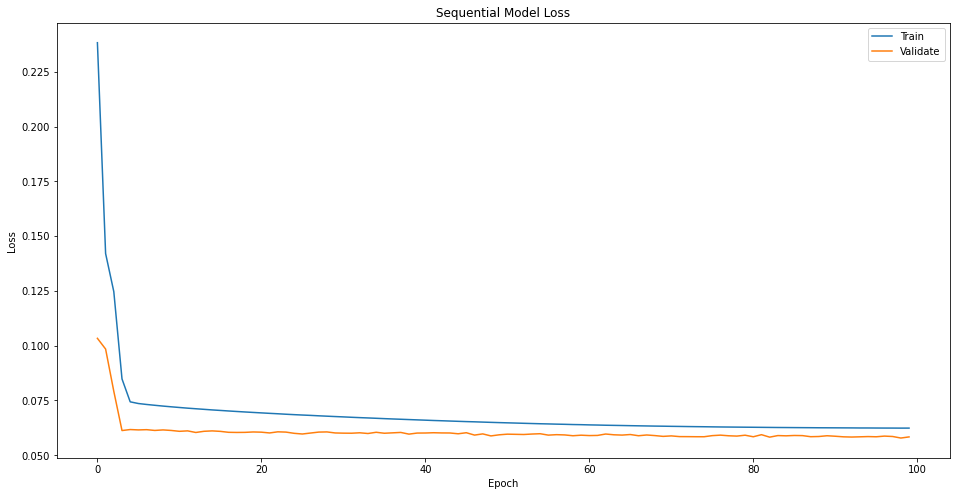

In [16]:
plt.figure(0, figsize=(16,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Sequential Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

Now we have trained our first multi-percetron autoencoder model. To get the condensed representation, we need to get the output from our "bottle neck" layer.

In [17]:
encoder = Model(inputs = sc_RNAseq_model.input, outputs = sc_RNAseq_model.get_layer('bottleneck').output)
bottleneck_representation = encoder.predict(X_scRNAseq)

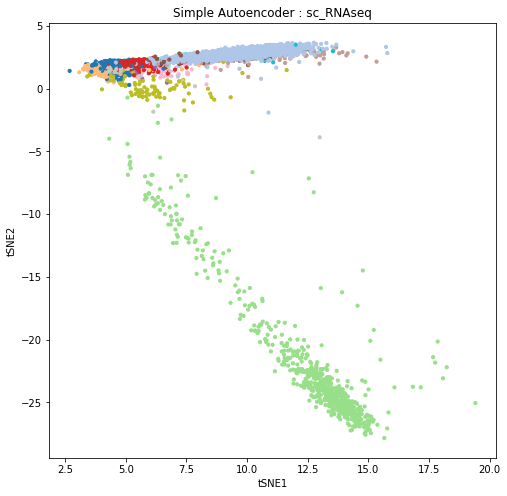

In [18]:
plt.figure(1, figsize=(8, 8))
plt.scatter(bottleneck_representation[:, 1], bottleneck_representation[:, 0], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title("Simple Autoencoder : sc_RNAseq")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

## Challenge 1: build your simple autoencoder 

Try to build an antoencoder for scProteomics data, which reduce the dimention of scProteomics data from 10 to 2. 

In [19]:
# simple Autoencoder Sequential Model
sc_Proteomics_model = Sequential([Input(shape=(X_scProteomics.shape[1],), name = 'input_layer'),
                              # adding your layers here


                              ])
# print the model summary
sc_Proteomics_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [20]:
sc_Proteomics_model.compile(loss = 'mean_squared_error', 
                        optimizer = 'adam',
                        metrics = ['mse', 'mae'])

history = sc_Proteomics_model.fit(X_scProteomics, X_scProteomics, batch_size = 128, epochs = 100, shuffle = True, verbose = 1, validation_split = 0.1)

Epoch 1/100
61/61 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 3/100
61/61 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 4/100
61/61 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 5/100
61/61 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - mse: 0.0000e+00 - mae: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 6/100
61/61 [==============================] - 0s 1ms/step 

## Autoencoder using TensorFlow Functional API

Advantages of Sequential Model:
* intuitive and simple to use
* quickly debug (when use with model.add() function)

Disadvantages:
* your models only have a single input and single output
* your models only have linear topology (e.g. you won't be able to add a residual connection)




Comparing to Sequential API, functional API is a way to create model with more flexibility. And functional API enables you to create more complex models (e.g. model with multiple inputs and outputs)

To use functional API, you need to specify the inputs and outputs for each layer in your model

In [21]:
# Tensorflow Functinonal Model

# Input Layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scProteomics = X_scProteomics.shape[1]
input_dim_scProteomics = Input(shape = (ncol_scProteomics, ), name = "scProteomics")

# Dimensions of Encoder for each OMIC
encoding_dim_scRNAseq = 50
encoding_dim_scProteomics = 10

# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation = 'linear', 
                         name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scProteomics = Dense(encoding_dim_scProteomics, activation = 'linear', 
                             name = "Encoder_scProteomics")(input_dim_scProteomics)

# Merging Encoder layers from different OMICs
merge = concatenate([encoded_scRNAseq, encoded_scProteomics])

# Bottleneck compression
bottleneck = Dense(50, kernel_initializer = 'uniform', activation = 'linear', 
                   name = "Bottleneck")(merge)

#Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scProteomics, 
                      activation = 'elu', name = "Concatenate_Inverse")(bottleneck)

# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation = 'sigmoid', 
                         name = "Decoder_scRNAseq")(merge_inverse)
decoded_scProteomics = Dense(ncol_scProteomics, activation = 'sigmoid', 
                             name = "Decoder_scProteomics")(merge_inverse)

# Combining Encoder and Decoder into an Autoencoder model
autoencoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                    outputs = [decoded_scRNAseq, decoded_scProteomics])

# Compile Autoencoder
autoencoder.compile(optimizer = 'adam', 
                    loss={'Decoder_scRNAseq': 'mean_squared_error', 
                          'Decoder_scProteomics': 'mean_squared_error'})
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scRNAseq (InputLayer)          [(None, 976)]        0           []                               
                                                                                                  
 scProteomics (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 Encoder_scRNAseq (Dense)       (None, 50)           48850       ['scRNAseq[0][0]']               
                                                                                                  
 Encoder_scProteomics (Dense)   (None, 10)           110         ['scProteomics[0][0]']           
                                                                                            

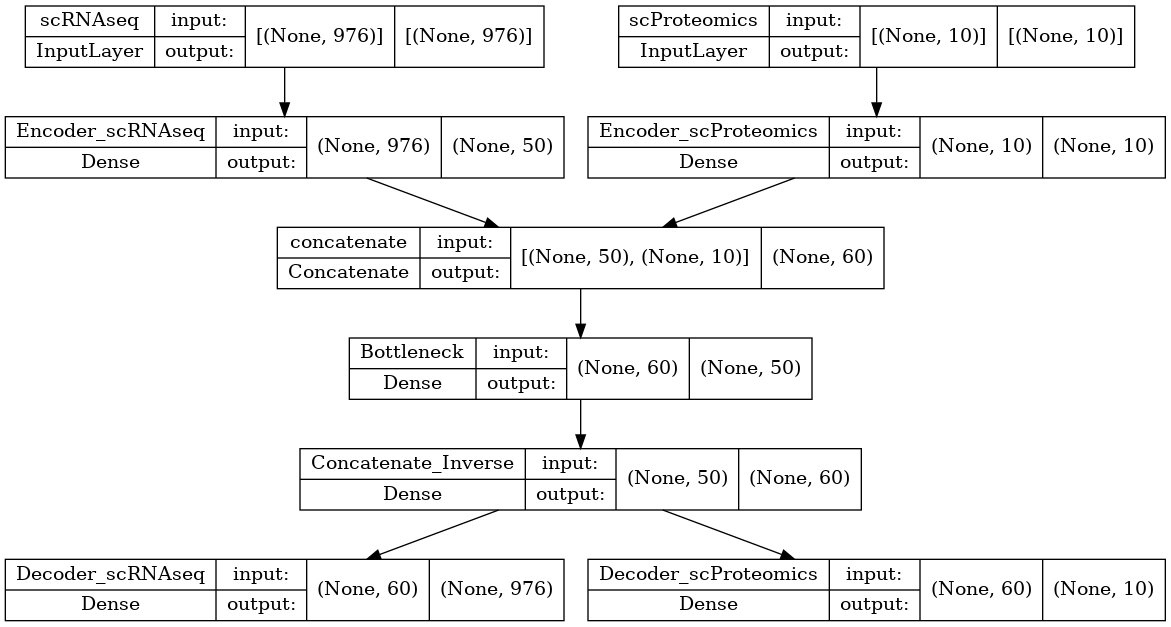

In [22]:
plot_model(autoencoder, show_shapes=True)

In [23]:
# Autoencoder training
estimator = autoencoder.fit([X_scRNAseq, X_scProteomics], 
                            [X_scRNAseq, X_scProteomics], 
                            epochs = 100, batch_size = 128, 
                            validation_split = 0.2, shuffle = True, verbose = 1)

Epoch 1/100
54/54 [==============================] - 1s 6ms/step - loss: 17.4416 - Decoder_scRNAseq_loss: 0.2747 - Decoder_scProteomics_loss: 17.1669 - val_loss: 15.3986 - val_Decoder_scRNAseq_loss: 0.0901 - val_Decoder_scProteomics_loss: 15.3085
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 17.0634 - Decoder_scRNAseq_loss: 0.2052 - Decoder_scProteomics_loss: 16.8583 - val_loss: 15.3883 - val_Decoder_scRNAseq_loss: 0.0799 - val_Decoder_scProteomics_loss: 15.3084
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 17.0565 - Decoder_scRNAseq_loss: 0.1983 - Decoder_scProteomics_loss: 16.8582 - val_loss: 15.3872 - val_Decoder_scRNAseq_loss: 0.0788 - val_Decoder_scProteomics_loss: 15.3084
Epoch 4/100
54/54 [==============================] - 0s 5ms/step - loss: 17.0546 - Decoder_scRNAseq_loss: 0.1963 - Decoder_scProteomics_loss: 16.8582 - val_loss: 15.3864 - val_Decoder_scRNAseq_loss: 0.0780 - val_Decoder_scProteomics_loss: 15.3084
Epoch 5/100


Training Loss:  17.034822463989258
Validation Loss:  15.370643615722656


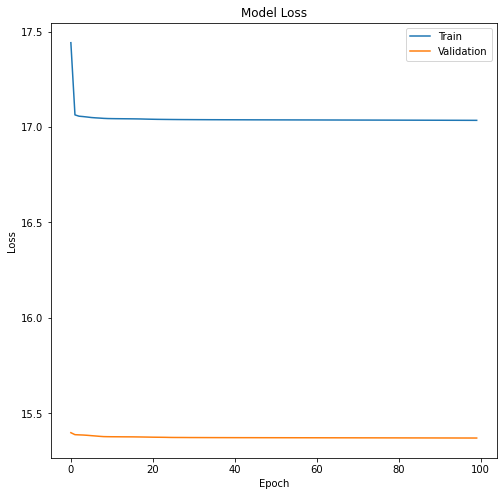

In [24]:
print("Training Loss: ",estimator.history['loss'][-1])
print("Validation Loss: ",estimator.history['val_loss'][-1])
fig = plt.figure(figsize=(8,8))
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper right')
plt.show()

# Encoder model
encoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                outputs = bottleneck)
bottleneck_representation = encoder.predict([X_scRNAseq, X_scProteomics])

Quiz: there is an "error" in the above model, can you find it?
- hint: look at above figure, what is the difference between functional model's loss figure and sequential model's loss figure

In [25]:
# tSNE on Autoencoder bottleneck representation
model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 500, verbose = 1, n_jobs=-1)
tsne_auto = model_tsne_auto.fit_transform(bottleneck_representation)

/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.001s...
[t-SNE] Computed neighbors for 8617 samples in 1.852s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 1.555480
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.910393
[t-SNE] KL divergence after 500 iterations: 1.661018


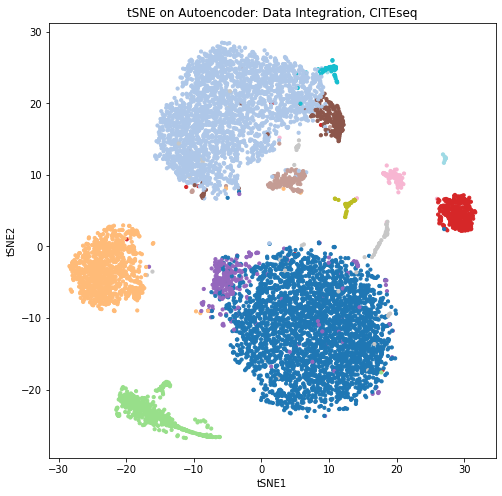

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
plt.title('tSNE on Autoencoder: Data Integration, CITEseq')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

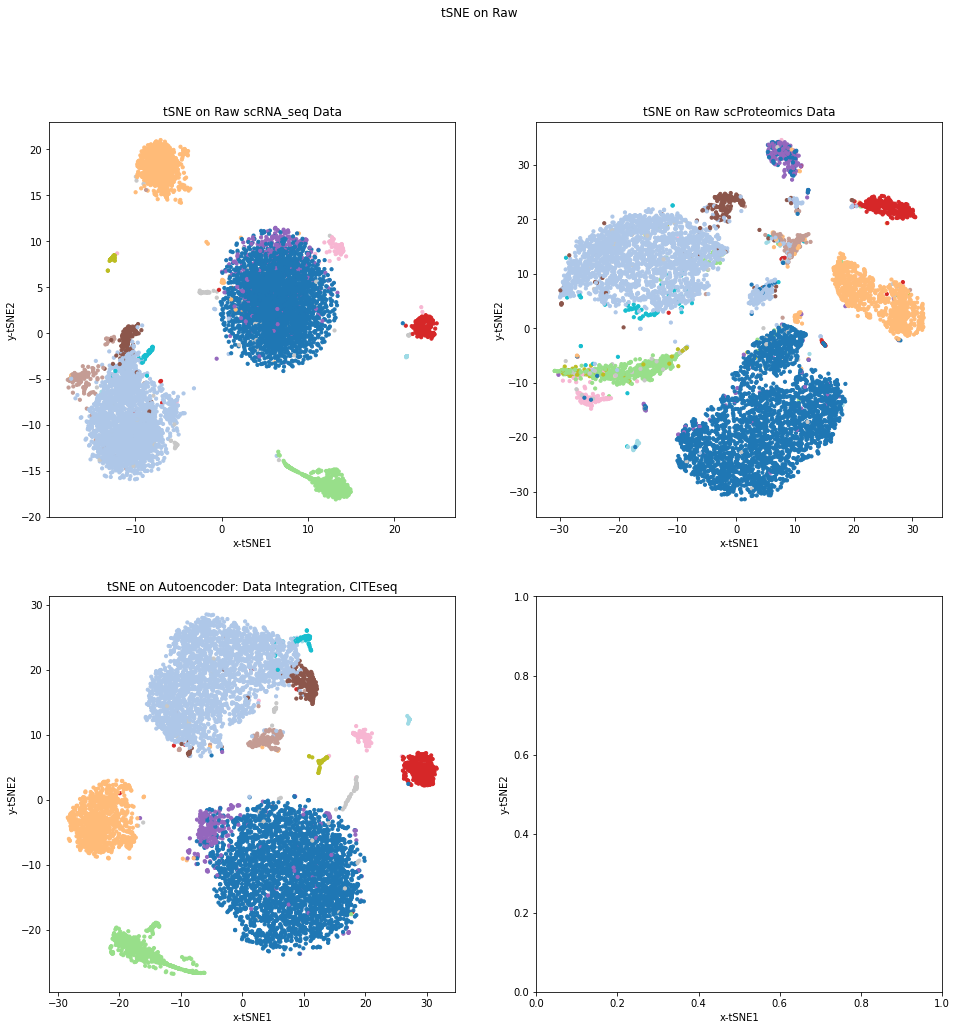

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))
fig.suptitle('tSNE on Raw ')

axs[0][0].scatter(scRNAseq_tsne[:, 0], scRNAseq_tsne[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
axs[0][0].set_title('tSNE on Raw scRNA_seq Data')

axs[0][1].scatter(scProteomics_tsne[:, 0], scProteomics_tsne[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 10)
axs[0][1].set_title('tSNE on Raw scProteomics Data')

axs[1][0].scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
axs[1][0].set_title('tSNE on Autoencoder: Data Integration, CITEseq')

for ax in axs.flat:
    ax.set(xlabel='x-tSNE1', ylabel='y-tSNE2')

##  Challenge 2: improve the AUTOENCODER multi-omics model

Tips:
*   change the activation function of the decoder 
*   add more hidden layers
*   add dropout layers
*   adjust the bottleneck dimension


In [28]:
# Input Layer
ncol_scRNAseq = X_scRNAseq.shape[1]
input_dim_scRNAseq = Input(shape = (ncol_scRNAseq, ), name = "scRNAseq")
ncol_scProteomics = X_scProteomics.shape[1]
input_dim_scProteomics = Input(shape = (ncol_scProteomics, ), name = "scProteomics")

# Dimensions of Encoder for each OMIC
encoding_dim_scRNAseq = 50
encoding_dim_scProteomics = 10

# Encoder layer for each OMIC
encoded_scRNAseq = Dense(encoding_dim_scRNAseq, activation = 'linear', 
                         name = "Encoder_scRNAseq")(input_dim_scRNAseq)
encoded_scProteomics = Dense(encoding_dim_scProteomics, activation = 'linear', 
                             name = "Encoder_scProteomics")(input_dim_scProteomics)

# Merging Encoder layers from different OMICs
merge = concatenate([encoded_scRNAseq, encoded_scProteomics])

# Encoder Hidden layer

encoder_hidden_dense = Dense(encoding_dim_scRNAseq+encoding_dim_scProteomics, activation='elu')(merge)

# Bottleneck compression
bottleneck = Dense(50, kernel_initializer = 'uniform', activation = 'linear', 
                   name = "Bottleneck")(encoder_hidden_dense)

#Inverse merging
merge_inverse = Dense(encoding_dim_scRNAseq + encoding_dim_scProteomics, 
                      activation = 'elu', name = "Concatenate_Inverse")(bottleneck)

# Decoder Hidden layer

decoder_hidden_dense = Dense(encoding_dim_scRNAseq+encoding_dim_scProteomics, activation='elu')(merge_inverse)

# Decoder layer for each OMIC
decoded_scRNAseq = Dense(ncol_scRNAseq, activation = 'linear', 
                         name = "Decoder_scRNAseq")(decoder_hidden_dense)
decoded_scProteomics = Dense(ncol_scProteomics, activation = 'linear', 
                             name = "Decoder_scProteomics")(decoder_hidden_dense)

# Combining Encoder and Decoder into an Autoencoder model
my_autoencoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                    outputs = [decoded_scRNAseq, decoded_scProteomics])

# Compile Autoencoder
my_autoencoder.compile(optimizer = 'adam', 
                    loss={'Decoder_scRNAseq': 'mean_squared_error', 
                          'Decoder_scProteomics': 'mean_squared_error'})
my_autoencoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scRNAseq (InputLayer)          [(None, 976)]        0           []                               
                                                                                                  
 scProteomics (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 Encoder_scRNAseq (Dense)       (None, 50)           48850       ['scRNAseq[0][0]']               
                                                                                                  
 Encoder_scProteomics (Dense)   (None, 10)           110         ['scProteomics[0][0]']           
                                                                                            

In [29]:
# Autoencoder training
my_estimator = my_autoencoder.fit([X_scRNAseq, X_scProteomics], 
                            [X_scRNAseq, X_scProteomics], 
                            epochs = 100, batch_size = 128, 
                            validation_split = 0.2, shuffle = True, verbose = 1)

Epoch 1/100
54/54 [==============================] - 1s 8ms/step - loss: 5.5809 - Decoder_scRNAseq_loss: 0.2586 - Decoder_scProteomics_loss: 5.3223 - val_loss: 1.0799 - val_Decoder_scRNAseq_loss: 0.0881 - val_Decoder_scProteomics_loss: 0.9918
Epoch 2/100
54/54 [==============================] - 0s 5ms/step - loss: 0.6784 - Decoder_scRNAseq_loss: 0.1865 - Decoder_scProteomics_loss: 0.4919 - val_loss: 0.5084 - val_Decoder_scRNAseq_loss: 0.0753 - val_Decoder_scProteomics_loss: 0.4330
Epoch 3/100
54/54 [==============================] - 0s 5ms/step - loss: 0.4237 - Decoder_scRNAseq_loss: 0.1173 - Decoder_scProteomics_loss: 0.3065 - val_loss: 0.3814 - val_Decoder_scRNAseq_loss: 0.0583 - val_Decoder_scProteomics_loss: 0.3230
Epoch 4/100
54/54 [==============================] - 0s 6ms/step - loss: 0.2957 - Decoder_scRNAseq_loss: 0.0690 - Decoder_scProteomics_loss: 0.2266 - val_loss: 0.3031 - val_Decoder_scRNAseq_loss: 0.0540 - val_Decoder_scProteomics_loss: 0.2490
Epoch 5/100
54/54 [=========

In [30]:
# Encoder model
my_encoder = Model(inputs = [input_dim_scRNAseq, input_dim_scProteomics], 
                outputs = bottleneck)
my_bottleneck_representation = my_encoder.predict([X_scRNAseq, X_scProteomics])

In [ ]:
# tSNE on Autoencoder bottleneck representation
my_model_tsne_auto = TSNE(learning_rate = 200, n_components = 2, random_state = 123, 
                       perplexity = 90, n_iter = 1000, verbose = 1, n_jobs=-1)
my_tsne_auto = my_model_tsne_auto.fit_transform(my_bottleneck_representation)

/g/data/ik06/stark/anaconda3/envs/deep_tf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.001s...
[t-SNE] Computed neighbors for 8617 samples in 1.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.418140
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.041733


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))
fig.suptitle('tSNE on Raw ')

axs[0][0].scatter(scRNAseq_tsne[:, 0], scRNAseq_tsne[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
axs[0][0].set_title('tSNE on Raw scRNA_seq Data')

axs[0][1].scatter(scProteomics_tsne[:, 0], scProteomics_tsne[:, 1], c = Y_scProteomics, cmap = 'tab20', s = 10)
axs[0][1].set_title('tSNE on Raw scProteomics Data')

axs[1][0].scatter(tsne_auto[:, 0], tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
axs[1][0].set_title('tSNE on Autoencoder: Data Integration, CITEseq')

axs[1][1].scatter(my_tsne_auto[:, 0], my_tsne_auto[:, 1], c = Y_scRNAseq, cmap = 'tab20', s = 10)
axs[1][1].set_title('tSNE on My Autoencoder: Data Integration, CITEseq')

for ax in axs.flat:
    ax.set(xlabel='x-tSNE1', ylabel='y-tSNE2')

## (optional) Autoencoders on ECG Anomaly detection
    > code copy from Tensorflow Official Tutorial
    * please go https://www.tensorflow.org/tutorials/generative/autoencoder#third_example_anomaly_detection for details

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
dataframe = pd.read_csv('ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

In [ ]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [ ]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

In [ ]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

# Summary:
1. using PCA, tSNE to do dimensionality reduction
2. using TensorFlow Sequential Model to build a simple autoencoder to do dimensionality reduction
3. using TensorFlow Functional API to build a autoencoder for OMIC integration 


Reference:
1. https://www.tensorflow.org/tutorials/generative/autoencoder
2. https://github.com/NikolayOskolkov/DeepLearningDataIntegration/blob/master/tSNE_on_Autoencoder_CITEseq.py


